In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from math import sqrt
from time import time
import os
import joblib
import itertools

import warnings
warnings.simplefilter("ignore")

# Data loading

In [2]:
df = pd.read_json("data.json").set_index('Id')
labels = pd.read_csv("label.csv", index_col='Id')
category_names = pd.read_csv("categories_string.csv")['0'].to_dict()

df['label'] = labels['Category']
df['job'] = labels['Category'].map(category_names)

# Utilities

In [3]:
def disparate_impact_df(df):
    counts = df.groupby(['label', 'gender']).size().unstack('gender')
    di = counts[['M', 'F']].max(axis='columns') / counts[['M', 'F']].min(axis='columns')
    di.index = di.index.map(category_names)
    return di.sort_values(ascending=False)

def disparate_impact(labels, genders):
    return disparate_impact_df(pd.DataFrame({'label': labels, 'gender': genders}))

def macro_disparate_impact(labels, genders):
    print("   macro fairness" + 25*" ", round(disparate_impact(labels, genders).mean(), 3))

In [4]:
import re
from time import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

def show_confusion_matrix(y_true, y_pred):
    _=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, y_pred)).plot(include_values=False)
    
def score_report(y_true, y_pred):
    r = classification_report(y_true, y_pred, target_names=category_names.values()).split("\n")
    for line in [re.sub("\\s+[^ ]+$","",e) for e in r[:1] + r[31:-1]]: print(line)
        
def print_score_report(clf, Y_train, y_pred_train, Y_test, y_pred_test, gender_train, gender_test):
    print("train")
    score_report(Y_train, y_pred_train)
    macro_disparate_impact(y_pred_train, gender_train)
    print("test")
    score_report(Y_test, y_pred_test)
    macro_disparate_impact(y_pred_test, gender_test)
    
def fit_model_test(model, X_train, X_test, Y_train, Y_test, test_on_train_set=True, test_on_test_set=True):
    t0 = time()
    model.fit(X_train, Y_train)
    print("train time: %0.3fs" % (time() - t0))
    
    if test_on_train_set:
        t0 = time()
        Y_pred_train = model.predict(X_train)
        print("test time (train set): %0.3fs" % (time() - t0))
    else: Y_pred_train = None
    
    if test_on_test_set:
        t0 = time()
        Y_pred_test = model.predict(X_test)
        print("test time (test set) : %0.3fs" % (time() - t0))
    else: Y_pred_test = None
    
    return [Y_pred_train, Y_pred_test]

In [5]:
import contextlib
import joblib
import os


@contextlib.contextmanager
def persist(name:str, dump:bool=True):
    if type(name) != str:
        raise TypeError("name must be a string")
    try:
        try: 
            var = globals()[name]
            yield var
        except KeyError:
            if os.path.isfile(name):
                print("loading " + name)
                yield joblib.load(name)
            else: yield
    finally:
        if dump:
            try:
                var = globals()[name]
                if var != None and not os.path.isfile(name):
                    joblib.dump(var, name)
                    print("dumped " + name)
            except KeyError: raise RuntimeError(name + " is not defined")

# Preprocessing

In [6]:
def preprocess(text):
    # remove : not character or space, digit, words with size < 3
    # to lowercase
    return re.sub(r'[^\w\s]|\d|\b\w{1,2}\b', ' ', str(text)).strip().lower()


lemmatizer = nltk.stem.WordNetLemmatizer()
# tokenizer with lemmatization
def tokenize(text):
    return [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)]


def full_preprocessing(text):
    l = tokenize(preprocess(text))
    return " ".join([w for w in l if w not in stop_words])

try: nltk.data.find('corpora/stopwords')
except LookupError: nltk.download('stopwords')
try: nltk.data.find('tokenizers/punkt')
except LookupError: nltk.download('punkt')
try: nltk.data.find('corpora/wordnet')
except LookupError: nltk.download('wordnet')
try: nltk.data.find('corpora/names')
except LookupError: nltk.download('names')

english_stopwords = nltk.corpus.stopwords.words("english")
male_names = [t.lower() for t in nltk.corpus.names.words('male.txt')]
female_names = [t.lower() for t in nltk.corpus.names.words('female.txt')]

# stopwords = common english + male and female names
stop_words = english_stopwords + list(
    itertools.chain.from_iterable(
        [tokenize(preprocess(t)) for t in male_names])) + list(
            itertools.chain.from_iterable(
                [tokenize(preprocess(t)) for t in female_names]))

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

with persist('tfidf_vectorizer') as tfidf_vectorizer:
    if tfidf_vectorizer == None:
        t0 = time()
        tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode',
                                            preprocessor=preprocess,
                                            tokenizer=tokenize,
                                            stop_words=stop_words,
                                            sublinear_tf=True).fit(df.description)
        print("preprocessing fit time : %0.3fs" % (time() - t0))

with persist('custom_X') as custom_X:
    if custom_X == None:
        t0 = time()
        custom_X = tfidf_vectorizer.transform(df.description)
        print("preprocessing time : %0.3fs" % (time() - t0))

X = custom_X

preprocessing fit time : 106.993s
dumped tfidf_vectorizer
preprocessing time : 109.268s
dumped custom_X


# Training

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2

X_selected = SelectPercentile(chi2, percentile=10).fit_transform(X, df.label)
X_selected.shape
X_s_train, X_s_test, Y_s_train, Y_s_test, G_s_train, G_s_test = train_test_split(X_selected,
                                                                                 df.label,
                                                                                 df.gender,
                                                                                 test_size=0.2,
                                                                                 random_state=211101)

In [9]:
from sklearn.svm import LinearSVC

with persist('linear_svm_model') as linear_svm_model:
    if linear_svm_model==None:
            linear_svm_model = LinearSVC(max_iter=1e9, # default : 1000
                                         tol=1e-5, # default : 1e-3
                                         C=0.1, # default : 1
                                         dual=False,
                                         random_state=211101)
            fit_model_test(linear_svm_model, X_s_train, X_s_test, Y_s_train, Y_s_test)

train time: 31.664s
test time (train set): 0.141s
test time (test set) : 0.042s
dumped linear_svm_model


# Evaluating

In [10]:
Y_s_pred_train = linear_svm_model.predict(X_s_train)
Y_s_pred_test = linear_svm_model.predict(X_s_test)
print_score_report(linear_svm_model, Y_s_train, Y_s_pred_train, Y_s_test, Y_s_pred_test, G_s_train, G_s_test)

train
                   precision    recall  f1-score
         accuracy                           0.83
        macro avg       0.83      0.76      0.79
     weighted avg       0.83      0.83      0.82
   macro fairness                          3.683
test
                   precision    recall  f1-score
         accuracy                           0.80
        macro avg       0.80      0.70      0.74
     weighted avg       0.80      0.80      0.79
   macro fairness                          3.258


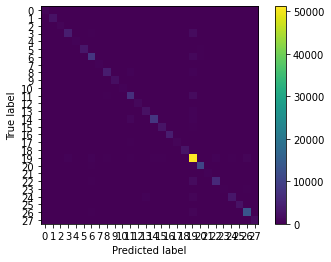

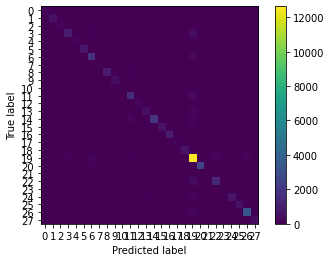

In [11]:
show_confusion_matrix(Y_s_train, Y_s_pred_train)
show_confusion_matrix(Y_s_test, Y_s_pred_test)

# Exporting 

In [26]:
predict = pd.DataFrame({
    'predicted': Y_s_pred_test,
    'true': Y_s_test
})
predict.predicted = predict.predicted.map(category_names)
predict.true = predict.true.map(category_names)
predict['description'] = df.iloc[predict.index].description
predict.to_csv('predict.csv', encoding="utf-8-sig'")